# Retail_Rocket Dataset processing
## Clicks and buys dataset 
This notebook describes pre-processing of retail_rocket dataset.

Both original and reproducibility papers only mention **clicks** and metrics related to clicks,  
however related codebase mises **buys** data with **clicks** data. While for RC15 dataset this   
mixing happens in preprocessing, retail_rocket dataset already contains sessions with clicks and   
buys. While for RC15, we take only clicks, here we take dataset as it is (i.e. with buy events).  

However, published code treats rewards for clicks and buys differently, which is not described   
in text of the papers. To keep consistency with RC15 data processing, we will need to set rewards  
for buys the same way as if it were clicks. Otherwise, RL and metrics methodology would differ  
between datasets.

In [1]:
#!/usr/bin/env python
import os
import pandas as pd

import numpy as np

from sklearn.preprocessing import LabelEncoder
from src.utils import *

import matplotlib.pyplot as plt

cur_dir = os.getcwd()
data_path = cur_dir + '/div4rec/retail_rocket_data/'
data_path_save = cur_dir + '/div4rec/retail_rocket_data/3+_only/'
os.makedirs(data_path_save, exist_ok=True)

### Start with original retail rocket dataset
We do not use any files produced in original paper and start preprocessing from the scratch.  
As such, input is events.csv from original dataset. Let's run next cell to see format of the data.

In [2]:
event_df = pd.read_csv(os.path.join(data_path, 'events.csv'), header=0)
event_df.columns = ['timestamp','session_id','behavior','item_id','transid']
###remove transid column
event_df =event_df[event_df['transid'].isnull()]
event_df = event_df.drop('transid',axis=1)
event_df.head(10)

,timestamp,session_id,behavior,item_id
0,1433221332117,257597,view,355908
1,1433224214164,992329,view,248676
2,1433221999827,111016,view,318965
3,1433221955914,483717,view,253185
4,1433221337106,951259,view,367447
5,1433224086234,972639,view,22556
6,1433221923240,810725,view,443030
7,1433223291897,794181,view,439202
8,1433220899221,824915,view,428805
9,1433221204592,339335,view,82389


Let's filter short sessions and low-population items. Paparella noted that removing short  
sessions first and then removing rare items results in appearance of new short sessions,  
however, he decided not to fix it due to comparability with Stamenkovic. As we further  
modify dataset to get rid of empty sequences (see clicks.ipynb) we need fix it (otherwise  
statistics as number of items in the dataset would be corrupted). Therefore, we first remove  
rare items and short sessions afterwards:

In [3]:
##########remove items with <=2 interactions
event_df['valid_item'] = event_df.item_id.map(event_df.groupby('item_id')['session_id'].size() > 2)
event_df = event_df.loc[event_df.valid_item].drop('valid_item', axis=1)

##########remove users with <=2 interactions
event_df['valid_session'] = event_df.session_id.map(event_df.groupby('session_id')['item_id'].size() > 2)
event_df = event_df.loc[event_df.valid_session].drop('valid_session', axis=1)

When comes to encoding original values of session_ids and item_ids to lower values,  
we also diverge from Paparella as he actually kept original values and created new columns for encoded  
values. If we have continued the same way function 'evaluate' would not work as well as training  
itself. It is likely Paparella created two datasets "nonencoding" and "encoding", but code  
to create later one is not available. See "nonencoding" in following code.

In [4]:
######## transform to ids
item_encoder = LabelEncoder()
session_encoder= LabelEncoder()
behavior_encoder=LabelEncoder()
event_df['item_id'] = item_encoder.fit_transform(event_df.item_id)
event_df['session_id'] = session_encoder.fit_transform(event_df.session_id)
event_df['behavior']=behavior_encoder.fit_transform(event_df.behavior)
###########sorted by user and timestamp
event_df['is_buy']=1-event_df['behavior']
event_df = event_df.drop('behavior', axis=1)
sorted_events = event_df.sort_values(by=['session_id', 'timestamp'])

sorted_events.head(20)

# sorted_events.to_csv('../div4rec/retail_rocket_data/sorted_events_noencoding.csv', index=None, header=True)

# to_pickled_df(data_directory, sorted_events=sorted_events)

,timestamp,session_id,item_id,is_buy
1361687,1442004589439,0,60456,0
1367212,1442004759591,0,75686,0
1367342,1442004917175,0,14031,0
742616,1438969904567,1,68703,0
735273,1438970013790,1,68703,0
737711,1438970212664,1,54951,0
726292,1438970468920,1,45692,0
737615,1438970905669,1,72501,0
735202,1438971444375,1,72501,0
742485,1438971463170,1,45692,0


#### Calculate item frequencies
We can not use item frequencies from original work as they have changed in previous step.  
Following cell creates less_popular_items.pkl and binary_nov_reward.csv files.

In [5]:
# Get Novel Items
item_freqs = sorted_events.item_id.value_counts()
threshold = np.quantile(item_freqs, q=0.9)
less_popular_items = []
for i in range(len(item_freqs)):
    if item_freqs.iloc[i] <= threshold:
        less_popular_items.append(item_freqs.index[i])
print('number of less popular items is: ', len(less_popular_items))
with open(f'{data_path_save}less_popular_items.pkl', 'wb') as f:
    pickle.dump(less_popular_items, f)

# Binary Novelty Reward System
for i in range(len(item_freqs)):
    if item_freqs.iloc[i] <= threshold:
        item_freqs.iloc[i] = 1
    else:
        item_freqs.iloc[i] = 0
item_freqs.to_csv(f'{data_path_save}binary_nov_reward.csv', header=False)

number of less popular items is:  88900


### Continue with split_data.py
Almost no changes from original scripts. We take our events data and split it to train,  
test and val.

In [6]:
total_sessions=sorted_events.session_id.unique()
np.random.shuffle(total_sessions)

fractions = np.array([0.8, 0.1, 0.1])
# split into 3 parts
train_ids, val_ids, test_ids = np.array_split(
    total_sessions, (fractions[:-1].cumsum() * len(total_sessions)).astype(int))
train_sessions=sorted_events[sorted_events['session_id'].isin(train_ids)]
val_sessions=sorted_events[sorted_events['session_id'].isin(val_ids)]
test_sessions=sorted_events[sorted_events['session_id'].isin(test_ids)]

to_pickled_df(data_path_save, sampled_train=train_sessions)
to_pickled_df(data_path_save, sampled_val=val_sessions)
to_pickled_df(data_path_save, sampled_test=test_sessions)

### Generate replay buffers for click data
Here we generate replay buffers for test, val and train datasets. Replay buffer  
is source of data further processed before loading by DataLoader. For detailed  
description see the same section in clicks.ipynb file.

In [8]:
state_size, item_num = get_stats(data_path)

def create_buffer(dataset_name, sorted_events, output_path, skip_length=0):
    pad_item = item_num
    groups = sorted_events.groupby('session_id')
    ids = sorted_events.session_id.unique()

    state, len_state, action, is_buy, next_state, len_next_state, is_done = [], [], [], [], [],[],[]
    statis_items = set()
    statis_sessions = {}
    statis_entries = 0
        
    for id in ids:
        group = groups.get_group(id)
        history = []
        counter=1
        for index, row in group.iterrows():
            s = list(history)
            len_s = state_size if len(s) >= state_size else 1 if len(s) == 0 else len(s)
            s = pad_history(s, state_size, pad_item)
            a = row['item_id']
            is_b = row['is_buy']
            history.append(row['item_id'])
            next_s = list(history)
            len_ns = state_size if len(next_s) >= state_size else 1 if len(next_s) == 0 else len(next_s)
            next_s=pad_history(next_s, state_size, pad_item)
            # sequences of skip_length or shorter are not added to dataset
            if counter > skip_length:
                state.append(s)
                len_state.append(len_s)
                action.append(a)
                is_buy.append(is_b)
                len_next_state.append(len_ns)
                next_state.append(next_s)
                is_done.append(False)
                statis_entries += 1
            counter+=1
            statis_items.add(a)
        count = counter - 1
        statis_sessions[count] = statis_sessions.get(count, 0) + 1
        is_done[-1] = True
    sum_statis_items = {"item_num": len(statis_items)}
    sum_statis_entries = {"entries_num": statis_entries}
    sorted_statis_sessions = {k: statis_sessions[k] for k in sorted(statis_sessions)}

    replay_buffer_dict = {
        'state': state,
        'len_state': len_state,
        'action': action,
        'is_buy': is_buy,
        'next_state': next_state,
        'len_next_states': len_next_state,
        'is_done': is_done
    }
    replay_buffer = pd.DataFrame(data=replay_buffer_dict)
    replay_buffer.to_pickle(output_path + f'replay_buffer_{dataset_name}_skip={skip_length}.df')
    with open(output_path + 'sessions_stats.df', "wb") as f:
        pickle.dump(sorted_statis_sessions, f)
        #sorted_statis_sessions.to_pickle(output_path + 'sessions_stats.df')
    with open(output_path + 'items_stats.df', "wb") as f:
        pickle.dump(sum_statis_items, f)
        #sum_statis_items.to_pickle(output_path + 'items_stats.df')
    with open(output_path + 'entries_stats.df', "wb") as f:
        pickle.dump(sum_statis_entries, f)

In [9]:
for dataset in ['val', 'test', 'train']:
    sorted_events = pd.read_pickle(data_path_save + f'sampled_{dataset}.df')
    for skip in [0, 1, 2]:
        newpath = data_path_save + f'{dataset}_skip_{skip}/'
        os.makedirs(newpath, exist_ok=True)
        create_buffer(dataset, sorted_events, newpath, skip)

SET:  val SKIP:  0
ITEMS:  36478
ENTRIES:  129764
SESSIONS Lengths Populations:  {3: 7496, 4: 3724, 5: 2208, 6: 1355, 7: 893, 8: 646, 9: 455, 10: 376, 11: 272, 12: 213, 13: 184, 14: 125, 15: 132, 16: 101, 17: 105, 18: 63, 19: 68, 20: 42, 21: 43, 22: 38, 23: 36, 24: 26, 25: 21, 26: 30, 27: 22, 28: 23, 29: 18, 30: 15, 31: 8, 32: 9, 33: 9, 34: 14, 35: 10, 36: 14, 37: 6, 38: 10, 39: 10, 40: 6, 41: 9, 42: 9, 43: 6, 44: 13, 45: 7, 46: 4, 47: 7, 48: 5, 49: 1, 50: 4, 51: 4, 52: 3, 53: 5, 54: 4, 55: 3, 56: 1, 57: 2, 58: 2, 59: 2, 60: 3, 63: 3, 64: 1, 65: 1, 66: 2, 67: 2, 68: 3, 69: 1, 70: 1, 71: 3, 73: 3, 74: 1, 75: 3, 76: 3, 77: 1, 78: 1, 79: 1, 82: 1, 83: 2, 84: 3, 85: 1, 86: 2, 90: 1, 91: 1, 93: 1, 96: 1, 97: 1, 98: 1, 100: 1, 102: 2, 104: 1, 108: 1, 110: 1, 111: 2, 112: 1, 113: 1, 114: 1, 117: 1, 122: 1, 125: 1, 126: 1, 130: 1, 131: 1, 134: 1, 142: 1, 149: 1, 171: 1, 175: 1, 176: 1, 192: 3, 196: 1, 227: 1, 236: 1, 251: 1, 268: 1, 277: 1, 333: 1, 339: 1, 370: 1, 382: 1, 391: 1, 409: 1, 459: 

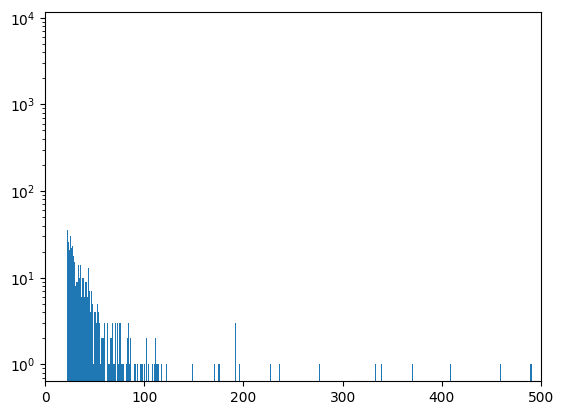

SET:  test SKIP:  0
ITEMS:  35924
ENTRIES:  124244
SESSIONS Lengths Populations:  {3: 7699, 4: 3572, 5: 2252, 6: 1276, 7: 885, 8: 626, 9: 484, 10: 327, 11: 271, 12: 228, 13: 176, 14: 168, 15: 102, 16: 97, 17: 88, 18: 64, 19: 64, 20: 52, 21: 52, 22: 39, 23: 42, 24: 30, 25: 31, 26: 39, 27: 27, 28: 15, 29: 10, 30: 10, 31: 16, 32: 12, 33: 15, 34: 14, 35: 14, 36: 12, 37: 10, 38: 10, 39: 11, 40: 11, 41: 7, 42: 4, 43: 5, 44: 4, 45: 5, 46: 7, 47: 9, 48: 3, 49: 5, 50: 5, 51: 7, 52: 2, 53: 4, 54: 1, 55: 6, 56: 1, 58: 2, 59: 4, 60: 4, 61: 4, 63: 2, 64: 2, 66: 1, 67: 2, 68: 4, 69: 4, 70: 1, 72: 2, 75: 2, 76: 1, 80: 1, 81: 1, 82: 2, 85: 1, 86: 3, 88: 1, 90: 2, 93: 1, 94: 1, 95: 1, 97: 2, 99: 1, 101: 1, 105: 1, 107: 1, 108: 1, 109: 1, 110: 1, 112: 2, 113: 1, 117: 1, 119: 1, 123: 1, 150: 1, 168: 2, 169: 1, 187: 1, 205: 1, 234: 1, 247: 2, 255: 1, 282: 1, 334: 1, 335: 1, 375: 1, 386: 1, 404: 1, 447: 1, 472: 1, 505: 1, 618: 1, 647: 1, 868: 1, 1388: 1, 1431: 1}
SET:  test SKIP:  1
ITEMS:  35924
ENTRIES: 

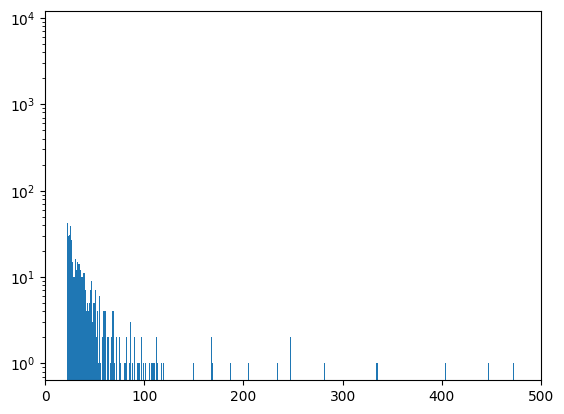

SET:  train SKIP:  0
ITEMS:  92491
ENTRIES:  1010360
SESSIONS Lengths Populations:  {3: 60645, 4: 29596, 5: 17479, 6: 10843, 7: 7173, 8: 5150, 9: 3735, 10: 2796, 11: 2137, 12: 1683, 13: 1384, 14: 1122, 15: 955, 16: 777, 17: 666, 18: 560, 19: 461, 20: 418, 21: 385, 22: 325, 23: 268, 24: 262, 25: 238, 26: 184, 27: 180, 28: 179, 29: 163, 30: 151, 31: 118, 32: 124, 33: 99, 34: 89, 35: 95, 36: 85, 37: 69, 38: 60, 39: 64, 40: 68, 41: 50, 42: 60, 43: 60, 44: 42, 45: 36, 46: 49, 47: 29, 48: 30, 49: 22, 50: 37, 51: 27, 52: 27, 53: 29, 54: 33, 55: 20, 56: 24, 57: 28, 58: 26, 59: 24, 60: 16, 61: 22, 62: 20, 63: 16, 64: 15, 65: 10, 66: 17, 67: 6, 68: 14, 69: 13, 70: 13, 71: 15, 72: 11, 73: 14, 74: 11, 75: 16, 76: 5, 77: 11, 78: 3, 79: 8, 80: 4, 81: 6, 82: 10, 83: 8, 84: 7, 85: 6, 86: 3, 87: 11, 88: 3, 89: 6, 90: 7, 91: 3, 92: 6, 93: 1, 94: 2, 95: 8, 96: 6, 97: 8, 98: 1, 99: 2, 100: 5, 101: 2, 102: 4, 103: 5, 104: 2, 105: 5, 106: 1, 107: 2, 108: 3, 109: 1, 110: 3, 111: 2, 112: 5, 113: 3, 114: 1, 11

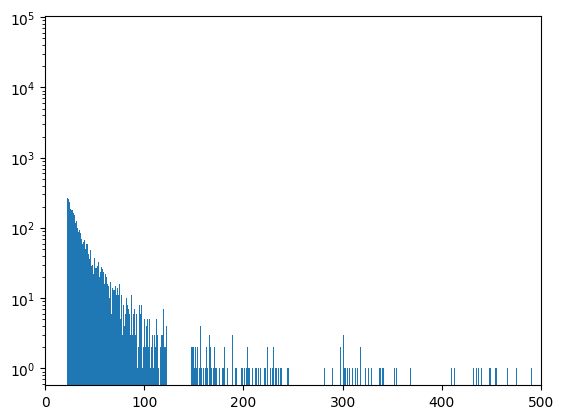

In [13]:
for dataset in ['val', 'test', 'train']:
    sorted_events = pd.read_pickle(data_path_save + f'sampled_{dataset}.df')
    for skip in [0, 1, 2]:
        newpath = data_path_save + f'{dataset}_skip_{skip}/'
        sessions_stats = pd.read_pickle(os.path.join(newpath, 'sessions_stats.df'))
        items_stats = pd.read_pickle(os.path.join(newpath, 'items_stats.df'))
        entries_stats = pd.read_pickle(os.path.join(newpath, 'entries_stats.df'))
        print('SET: ', dataset, 'SKIP: ', skip)
        print('ITEMS: ', items_stats["item_num"])
        print('ENTRIES: ', entries_stats["entries_num"])
        print('SESSIONS Lengths Populations: ', sessions_stats)
        
    x = list(sessions_stats.keys())
    y = list(sessions_stats.values())
    plt.bar(x, y)
    plt.yscale("log")
    plt.xlim((0,500))
    plt.show()

In [14]:
check_df = pd.read_pickle(data_path_save + "test_skip_0/replay_buffer_test_skip=0.df")
check_df.head(20)

,state,len_state,action,is_buy,next_state,len_next_states,is_done
0,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,13665,1,"[13665, 70852, 70852, 70852, 70852, 70852, 708...",1,False
1,"[13665, 70852, 70852, 70852, 70852, 70852, 708...",1,53625,0,"[13665, 53625, 70852, 70852, 70852, 70852, 708...",2,False
2,"[13665, 53625, 70852, 70852, 70852, 70852, 708...",2,72903,0,"[13665, 53625, 72903, 70852, 70852, 70852, 708...",3,False
3,"[13665, 53625, 72903, 70852, 70852, 70852, 708...",3,72903,0,"[13665, 53625, 72903, 72903, 70852, 70852, 708...",4,False
4,"[13665, 53625, 72903, 72903, 70852, 70852, 708...",4,72903,0,"[13665, 53625, 72903, 72903, 72903, 70852, 708...",5,False
5,"[13665, 53625, 72903, 72903, 72903, 70852, 708...",5,72903,0,"[13665, 53625, 72903, 72903, 72903, 72903, 708...",6,True
6,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,61739,0,"[61739, 70852, 70852, 70852, 70852, 70852, 708...",1,False
7,"[61739, 70852, 70852, 70852, 70852, 70852, 708...",1,84919,0,"[61739, 84919, 70852, 70852, 70852, 70852, 708...",2,False
8,"[61739, 84919, 70852, 70852, 70852, 70852, 708...",2,61739,0,"[61739, 84919, 61739, 70852, 70852, 70852, 708...",3,False
9,"[61739, 84919, 61739, 70852, 70852, 70852, 708...",3,84919,0,"[61739, 84919, 61739, 84919, 70852, 70852, 708...",4,False
